In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

### Transitions

In [2]:
LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3
ACTION_SPACE = [LEFT,DOWN,RIGHT,UP]
numstates  = 12
numactions = 4

In [3]:
colNum = 4
transition_prob = 1
transitions = np.zeros((numstates, numactions, numstates))
nextStates = np.zeros((numstates, numactions), dtype=int)
for a in range(numactions):
    for i in range(numstates):
        if ((i//colNum == 0) & (a == 3)) or (((numstates-i-1)//colNum == 0) & (a == 1)) or \
           ((i%colNum  == 0) & (a == 0)) or ((i%colNum  == (colNum-1)) & (a == 2)):
            transitions[i, a, i] = transition_prob
        
        elif a == 0:
            transitions[i, a, i-1] = transition_prob
        
        elif a == 1:
            transitions[i, a, i+colNum] = transition_prob
        
        elif a == 2:
            transitions[i, a, i+1] = transition_prob
        
        elif a == 3:
            transitions[i, a, i-colNum] = transition_prob
            
    
# obstacles
transitions[5, 0, 4] = 0
transitions[5, 0, 5] = 1
transitions[0, 1, 4] = 0
transitions[0, 1, 0] = 1
transitions[8, 3, 4] = 0
transitions[8, 3, 8] = 1
for s in [2, 4, 11]:
    transitions[s,:,:] = 0
    transitions[s,:,s] = 1

### Rewards

In [4]:
rewards = np.zeros((numstates,numstates))
rewards[7, 11] = 10
rewards[10, 11] = 10
rewards[1, 2] = -10
rewards[3, 2] = -10
rewards[6, 2] = -10

## Algorithms

### Policy iteration

In [5]:
def Policy_Evaluation(V, probability):
    counter = 0
    while True:
        counter += 1
        delta = 0
        for state in range(numstates):

            v = V[state].copy()
            q = np.sum(transitions[state] * (rewards[state] + Discount * np.tile(V, (numactions, 1)) ), axis=1)
            V[state] = np.sum(probability[state] * q)
            delta = max(delta, np.abs(v - V[state]))

        if delta < theta:
            break
            
    return V, counter

In [6]:
def Policy_Improvment(V, probability):
    policy_stable = True
    for state in range(numstates):
        if state in [2, 4, 11]:
            continue

        old = probability[state].copy()
        q = np.sum(transitions[state] * (rewards[state] + Discount * np.tile(V, (numactions, 1)) ), axis=1)
        opt_act = np.argmax(q)
        probability[state] = np.eye(numactions)[opt_act]
        if (probability[state] != old).any():
            policy_stable = False

    return policy_stable, probability

In [7]:
def Policy_Iteration():
    V = np.zeros(numstates)
    probability = np.full((numstates, numactions), fill_value=0.25)
    probability[[2, 4, 11]] = 0
    counter = 0
    start = time.time()
    while True:
        counter += 1
        updated_value, eval_iters = Policy_Evaluation(V, probability)
        policy_stable, updated_probability = Policy_Improvment(updated_value, probability)
        print(f'----------------------------------\nIteration: {counter}\nNumber of Evaluation Iterations: {eval_iters}')
        render(updated_value, updated_probability)
        if policy_stable:
            end = time.time()
            break
            
    return updated_value, updated_probability

### Value iteration

In [8]:
def Value_Iteration():
    V = np.zeros(numstates)
    probability = np.full((numstates, numactions), fill_value=0.25)
    probability[[2, 4, 11]] = 0
    start = time.time()
    counter = 0
    while True:
        counter += 1
        delta = 0
        for state in range(numstates):

            v = V[state].copy()
            q = np.sum(transitions[state] * (rewards[state] + Discount * np.tile(V, (numactions, 1)) ), axis=1)
            V[state] = np.max(q)
            delta = max(delta, np.abs(v - V[state]))
        
        print(f'----------------------------------\nIteration: {counter}')
        print(V.reshape((3,4)))
        if delta < theta:
            break

    # policy improvement
    for state in range(numstates):
        if state in [2, 4, 11]:
            continue

        q = np.sum(transitions[state] * (rewards[state] + Discount * np.tile(V, (numactions, 1)) ), axis=1)
        opt_act = np.argmax(q)
        probability[state] = np.eye(numactions)[opt_act]

    end = time.time()
    print('----------------------------------\n\nFinal:')
    render(V, probability)
    return V, probability

### Render

In [9]:
def render(values, policy):
    shape = np.array([3,4])
    probs = np.zeros([shape[0],shape[1],2])
    probabilities = policy.reshape([shape[0],shape[1],4])
    for i in range(shape[0]):
        for j in range(shape[1]):
            argmax = np.argwhere(probabilities[i,j,:]==1)
            if 0 in argmax:
                probs[i,j] = np.array([-1,0])
            if 1 in argmax:
                probs[i,j] = np.array([0,-1])
            if 2 in argmax:
                probs[i,j] = np.array([1,0])
            if 3 in argmax:
                probs[i,j] = np.array([0,1])

    plt.figure(figsize=(8,5))
    sns.heatmap(values.reshape(shape), annot=True, cbar=False, fmt='.2f',
                linewidths=0.4, linecolor='gray', cmap='Blues_r', annot_kws={'size':20})
    for x in range(shape[0]):
        for y in range(shape[1]):
            plt.quiver(y+.5, x+.8, probs[x,y,0], probs[x,y,1], scale=30, 
                       width=0.004, headwidth=8, color='#3A4F7A')
    plt.title('Values & Policies', fontsize=20)
    plt.xticks([])
    plt.yticks([])
    plt.show()


# Q1

----------------------------------
Iteration: 1
Number of Evaluation Iterations: 2


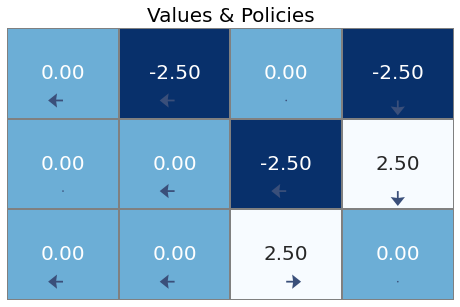

----------------------------------
Iteration: 2
Number of Evaluation Iterations: 2


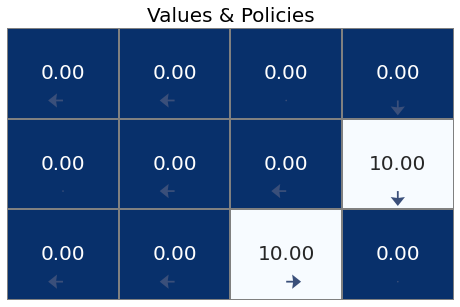

In [10]:
Discount = 0
theta = 0.01
values, policy = Policy_Iteration()

# Q2

----------------------------------
Iteration: 1
Number of Evaluation Iterations: 19


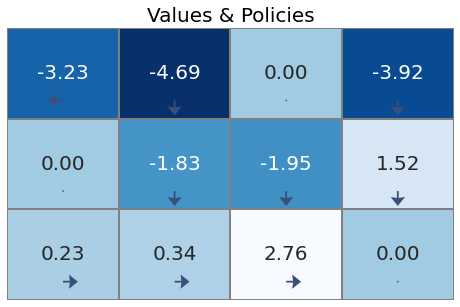

----------------------------------
Iteration: 2
Number of Evaluation Iterations: 34


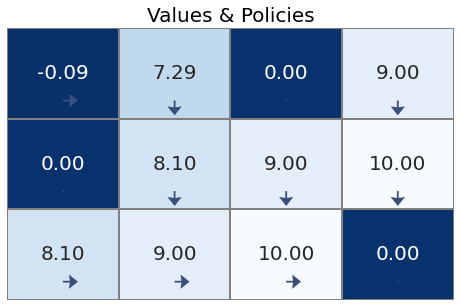

----------------------------------
Iteration: 3
Number of Evaluation Iterations: 2


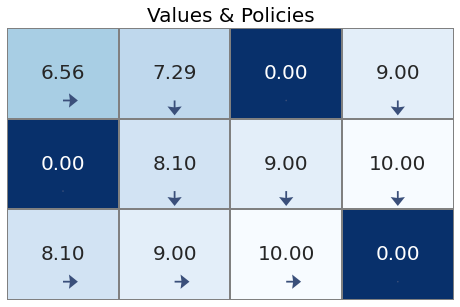

In [11]:
Discount = 0.9
theta = 0.01
values, policy = Policy_Iteration()

# Q3

----------------------------------
Iteration: 1
[[ 0.  0.  0.  0.]
 [ 0.  0.  0. 10.]
 [ 0.  0. 10.  0.]]
----------------------------------
Iteration: 2
[[ 0.  0.  0.  9.]
 [ 0.  0.  9. 10.]
 [ 0.  9. 10.  0.]]
----------------------------------
Iteration: 3
[[ 0.   0.   0.   9. ]
 [ 0.   8.1  9.  10. ]
 [ 8.1  9.  10.   0. ]]
----------------------------------
Iteration: 4
[[ 0.    7.29  0.    9.  ]
 [ 0.    8.1   9.   10.  ]
 [ 8.1   9.   10.    0.  ]]
----------------------------------
Iteration: 5
[[ 6.561  7.29   0.     9.   ]
 [ 0.     8.1    9.    10.   ]
 [ 8.1    9.    10.     0.   ]]
----------------------------------
Iteration: 6
[[ 6.561  7.29   0.     9.   ]
 [ 0.     8.1    9.    10.   ]
 [ 8.1    9.    10.     0.   ]]
----------------------------------

Final:


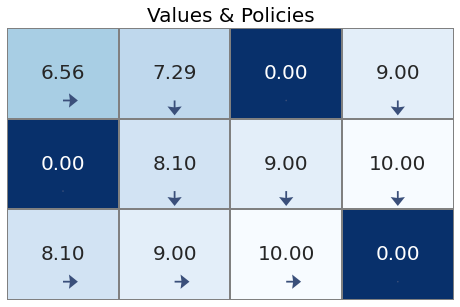

In [12]:
Discount = 0.9
theta = 0.01
values, policy = Value_Iteration()

---

---